In [1]:
%load_ext autoreload
%autoreload 2

# Validation Notebook

In [53]:
import xarray as xr
import xskillscore as xs
import numpy as np
import os
import datetime
from IPython.display import display
from matplotlib import pyplot as plt

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
xr.set_options(keep_attrs=True)
xr.set_options(display_style='text')

In [5]:
SHOW_VISUALISATIONS: bool = True

EXPORT_DATA: bool = False

In [114]:
OUTPUT = '***BASEDIR***'
EXPORT_PATH = '***HOME***Projets/S2S-Competition/outputs'
CMAP = "coolwarm"
CMAP = "RdYlGn"

# Validation class

In [7]:
import os
import xarray as xr
import pandas as pd
import cartopy.crs as ccrs


class Validation():
    def __init__(self, observation_path: str, prediction_path: str) -> None:
        
        if not os.path.exists(observation_path):
            print("Observation path file is not existing or unreachable")
            return
        if not os.path.exists(prediction_path):
            print("Prediction path file is not existing or unreachable")
            return
   
        self.observation_path = observation_path
        self.prediction_path = prediction_path
        
        self.obs: xr.Dataset = xr.Dataset()
        self.preds: xr.Dataset = xr.Dataset()
        self.clim_p: xr.DataArray = xr.DataArray()
            
        self.rps_ml: xr.Dataset = xr.Dataset()
        self.rps_clim: xr.Dataset = xr.Dataset()
            
        self.regions_positions: dict = {'North_America': (slice(0, 50), slice(120, 300)),
                                        'South_America': (slice(40, 100), slice(150, 300)),
                                        'Europe_Africa_Asia': (slice(0, 100), slice(0, 60)),
                                        'Oceania': (slice(50, 100), slice(70, 120))}
            
        self.regions_positions_orthographic: dict = {'North_America': (-80, 25),
                                                     'South_America': (-60, -15),
                                                     'Europe_Africa_Asia': (50, 25),
                                                     'Oceania': (120, 1)}

        self.__open_files()
        self.__initialise_climatology_probabilities()
        self.__assert_predictions_2020(self.obs)
        self.__assert_predictions_2020(self.preds)
        self.rps_ml, self.rps_clim = self.__compute_RPS(self.preds, self.obs, self.clim_p)

        print("Validation class successfully initialised")
        
    
    def __open_files(self) -> None:      
        try:
            self.obs = xr.open_dataset(self.observation_path)
            self.preds = xr.open_dataset(self.prediction_path)
        except Exception as e:
            print('Found Exception', str(e))
            
            
    def __initialise_climatology_probabilities(self) -> None:
        """
        REFORMAT FROM ORGANIZERS NOTEBOOKS
        Initialize the climatology DataArray to 1/3 values for each categories
        """
        self.clim_p = xr.DataArray([1/3, 1/3, 1/3], dims='category', coords={'category':['below normal', 'near normal', 'above normal']}).to_dataset(name='tp')
        self.clim_p['t2m'] = self.clim_p['tp']
        
    def __assert_predictions_2020(self, preds_test) -> None:
        """
        REFORMAT FROM ORGANIZERS NOTEBOOKS
        Check the variables, coordinates and dimensions of 2020 predictions.
        """
        
        # is dataset
        assert isinstance(preds_test, xr.Dataset)

        # has both vars: tp and t2m
        assert 'tp' in preds_test.data_vars
        assert 't2m' in preds_test.data_vars

        ## coords
        # forecast_time
        d = pd.date_range(start='2020-01-02', freq='7D', periods=53)
        forecast_time = xr.DataArray(d, dims='forecast_time', coords={'forecast_time':d})
        assert (forecast_time == preds_test['forecast_time']).all()

        # longitude
        lon = np.arange(0., 360., 1.5)
        longitude = xr.DataArray(lon, dims='longitude', coords={'longitude': lon})
        assert (longitude == preds_test['longitude']).all()

        # latitude
        lat = np.arange(90., -90.1, 1.5)
        latitude = xr.DataArray(lat, dims='latitude', coords={'latitude': lat})
        assert (latitude == preds_test['latitude']).all()

        # lead_time
        lead = [pd.Timedelta(f'{i} d') for i in [14, 28]]
        lead_time = xr.DataArray(lead, dims='lead_time', coords={'lead_time': lead})
        assert (lead_time == preds_test['lead_time']).all()

        # category
        cat = np.array(['below normal', 'near normal', 'above normal'], dtype='<U12')
        category = xr.DataArray(cat, dims='category', coords={'category': cat})
        assert (category == preds_test['category']).all()

        # size
        from dask.utils import format_bytes
        size_in_MB = float(format_bytes(preds_test.nbytes).split(' ')[0])
        assert size_in_MB > 50
        assert size_in_MB < 250

        # no other dims
        assert set(preds_test.dims) - {'category', 'forecast_time', 'latitude', 'lead_time', 'longitude'} == set()
        
        
    def __compute_RPS2(self):
        self.rps_ml = xs.rps(self.obs, self.preds, category_edges=None, dim='forecast_time', input_distributions='p').compute()               
        self.rps_clim = xs.rps(self.obs, self.clim_p, category_edges=None, dim='forecast_time', input_distributions='p').compute()
        
    def __compute_RPS(self, preds, obs, clim_p):   
        rps_ml = xs.rps(obs, preds, category_edges=None, dim='forecast_time', input_distributions='p').compute()  
        rps_clim = xs.rps(obs, clim_p, category_edges=None, dim='forecast_time', input_distributions='p').compute()      
        return rps_ml, rps_clim
            
    def plot_rps(self) -> None:
        for v in self.rps_ml.data_vars:
            self.rps_ml[v].plot(robust=True, col='lead_time', figsize=(10,5))

        for v in self.rps_clim.data_vars:
            self.rps_clim[v].plot(robust=True, col='lead_time', figsize=(10,5))
        
    def __compute_tropic_mask(self, rpss: xr.Dataset) -> xr.Dataset:
        
        mask = xr.ones_like(rpss.isel(lead_time=0, drop=True)).reset_coords(drop=True).t2m
        boundary_tropics = 30
        mask = xr.concat([mask.where(mask.latitude > boundary_tropics),
                          mask.where(np.abs(mask.latitude) <= boundary_tropics),
                          mask.where((mask.latitude < -boundary_tropics) & (mask.latitude > -60))], 'area')
        mask = mask.assign_coords(area=['northern_extratropics', 'tropics', 'southern_extratropics'])
        mask.name = 'area'

        return mask.where(rpss.t2m.isel(lead_time=0, drop=True).notnull())
    
    def __compute_rpss_organizers(self, rps_ml, rps_clim) -> xr.Dataset:
        return (1 - rps_ml / rps_clim)
        
    def compute_scores_from_organizers_RPSS(self) -> pd.DataFrame:
        """
        REFORMAT FROM ORGANIZERS NOTEBOOKS
        Compute RPSS according to notebook organizers
        """
        rpss_organizers = self.__compute_rpss_organizers(self.rps_ml, self.rps_clim)
        
        mask = self.__compute_tropic_mask(self.rps_ml)      
        weights = np.cos(np.deg2rad(np.abs(mask.latitude)))
        
        scores = (rpss_organizers*mask).weighted(weights).mean('latitude').mean('longitude')
        
        return scores.reset_coords(drop=True).to_dataframe().unstack(0).T.round(2)
        
    def compute_scores_from_arlan_RPSS(self) -> pd.DataFrame:
        """
        Compute RPSS according to Arlan's definition
        """
        
        mask = self.__compute_tropic_mask(self.rps_ml)      
        weights = np.cos(np.deg2rad(np.abs(mask.latitude)))
        
        latitude_longitude_sum_ML = (self.rps_ml*mask).weighted(weights).sum(dim=['latitude', 'longitude'])
        latitude_longitude_sum_clim = (self.rps_clim*mask).weighted(weights).sum(dim=['latitude', 'longitude'])
        
        rpss_arlan = 1 - latitude_longitude_sum_ML/latitude_longitude_sum_clim
        
        scores = (rpss_arlan*mask).weighted(weights).mean('latitude').mean('longitude')
        
        return scores.reset_coords(drop=True).to_dataframe().unstack(0).T.round(2)
    
    def __extract_from_month(self, xr_data: xr.Dataset, date: str ="2020-01") -> xr.Dataset:
        position = np.where(xr_data.forecast_time.data.astype("datetime64[M]") == np.datetime64(date))[0]
        return xr_data.isel(forecast_time=slice(position.min(), position.max()))
    
    def compute_monthly_scores(self, keep_tropics:bool = False) -> pd.DataFrame:
        
        scores_dict: dict = dict()
        date_list:list = list()
        for month in range(12):                       
            date = (str("2020-0") + str(month+1) if month + 1 <= 9 else str("2020-") + str(month+1))
            
            obs = self.__extract_from_month(xr_data = self.obs, date=date)
            preds = self.__extract_from_month(xr_data = self.preds, date=date)          
            rps_ml, rps_clim = self.__compute_RPS(preds, obs, self.clim_p)          
            rpss_organizers = self.__compute_rpss_organizers(rps_ml, rps_clim)
            
            mask = self.__compute_tropic_mask(rps_ml)      
            weights = np.cos(np.deg2rad(np.abs(mask.latitude)))
            
            if keep_tropics:
                scores = (rpss_organizers*mask).weighted(weights).mean('latitude').mean('longitude')
            else:                 
                scores = rpss_organizers.weighted(weights).mean('latitude').mean('longitude')   
                
            scores_dict[date] = scores.reset_coords(drop=True).to_dataframe().unstack(0).T.round(2)
            date_list.append(date)
         
        scores = pd.concat(list(scores_dict.values()), axis=1)
        
        if keep_tropics:
            index = [(month, (timed[0], timed[1])) for month, timed in zip(date_list, [(scores.columns[0], scores.columns[1]) for i in range(24)])]
            
            new_index = list()
            for item in index:
                new_index.append((item[0], item[1][0]))
                new_index.append((item[0], item[1][1]))

            scores.columns = pd.MultiIndex.from_tuples(new_index)
        else:
            scores.columns = date_list
            
        return scores
    
    def compute_trimestrial_scores(self):
        
        first_trimestrial = ("2020-01", "2020-04")
        second_trimestrial= ("2020-05", "2020-08")
        third_trimestrial = ("2020-09", "2020-12")
              
        scores_list: list = list()
        for trimestrial in [first_trimestrial, second_trimestrial, third_trimestrial]:
            position = np.where((val.preds.forecast_time.data.astype("datetime64[M]") >= np.datetime64(trimestrial[0])) & 
                                (val.preds.forecast_time.data.astype("datetime64[M]") <= np.datetime64(trimestrial[1])))[0]
            
            obs = self.obs.isel(forecast_time=slice(position.min(), position.max()))
            preds = self.preds.isel(forecast_time=slice(position.min(), position.max()))
            rps_ml, rps_clim = self.__compute_RPS(preds, obs, self.clim_p)
            rpss_organizers = self.__compute_rpss_organizers(rps_ml, rps_clim)
            mask = self.__compute_tropic_mask(self.rps_ml)      
            weights = np.cos(np.deg2rad(np.abs(mask.latitude)))
            scores = rpss_organizers.weighted(weights).mean('latitude').mean('longitude')
            scores_list.append(scores.reset_coords(drop=True).to_dataframe().unstack(0).T.round(2))
            
        scores_list = pd.concat(scores_list, axis=1)
        scores_list.columns = ["2020-01 to 2020-04", "2020-05 to 2020-08", "2020-09 to 2020-12"]
        return scores_list
    
    
    def plot_by_region(self, what:str='observations', feat:str='t2m', region:str='North_America', category:int=2, forecast_time:int=0, orthographic: bool=False):
        
        assert 't2m' or 'tp' in feat
        assert region in list(val.regions_positions.keys())
        assert category <= 2
        
        print('Plot', feat,'for category n°', category, 'for', what, 'data for', region, 'for forecast_time', forecast_time)
        
        latitude: slice = self.regions_positions[region][0]
        longitude: slice = self.regions_positions[region][1]
            
        orthographic_pos = self.regions_positions_orthographic[region]
                    
        if what == 'observations':
            if not orthographic:
                self.obs[feat].isel(category=category, 
                                    forecast_time=forecast_time, 
                                    latitude=latitude, 
                                    longitude=longitude).plot(col='lead_time', figsize=(10,5))
            else:
                self.obs[feat].isel(category=category, 
                                    forecast_time=forecast_time).plot(col='lead_time', subplot_kws=dict(projection=ccrs.Orthographic(orthographic_pos[0], orthographic_pos[1]), facecolor="gray"),
                                                                     transform=ccrs.PlateCarree(), 
                                                                     figsize=(20,20))
        elif what == 'predictions':
            if not orthographic:
                self.preds[feat].isel(category=category, 
                                      forecast_time=forecast_time, 
                                      latitude=latitude, 
                                      longitude=longitude).plot(col='lead_time', figsize=(10,5))
            else:
                self.preds[feat].isel(category=category, 
                                    forecast_time=forecast_time).plot(col='lead_time', subplot_kws=dict(projection=ccrs.Orthographic(orthographic_pos[0], orthographic_pos[1]), facecolor="gray"),
                                                                      transform=ccrs.PlateCarree(),
                                                                      figsize=(20,20))
        else:
            print(what, 'is not in possible visualisation. Try observations or predictions')

In [8]:
val = Validation(os.path.join(OUTPUT, 'forecast-like-observations_2020_biweekly_terciled.nc'), 
                 os.path.join(OUTPUT, 'ML_prediction_2020.nc'))

Validation class successfully initialised


Plot t2m for category n° 2 for predictions data for North_America for forecast_time 0


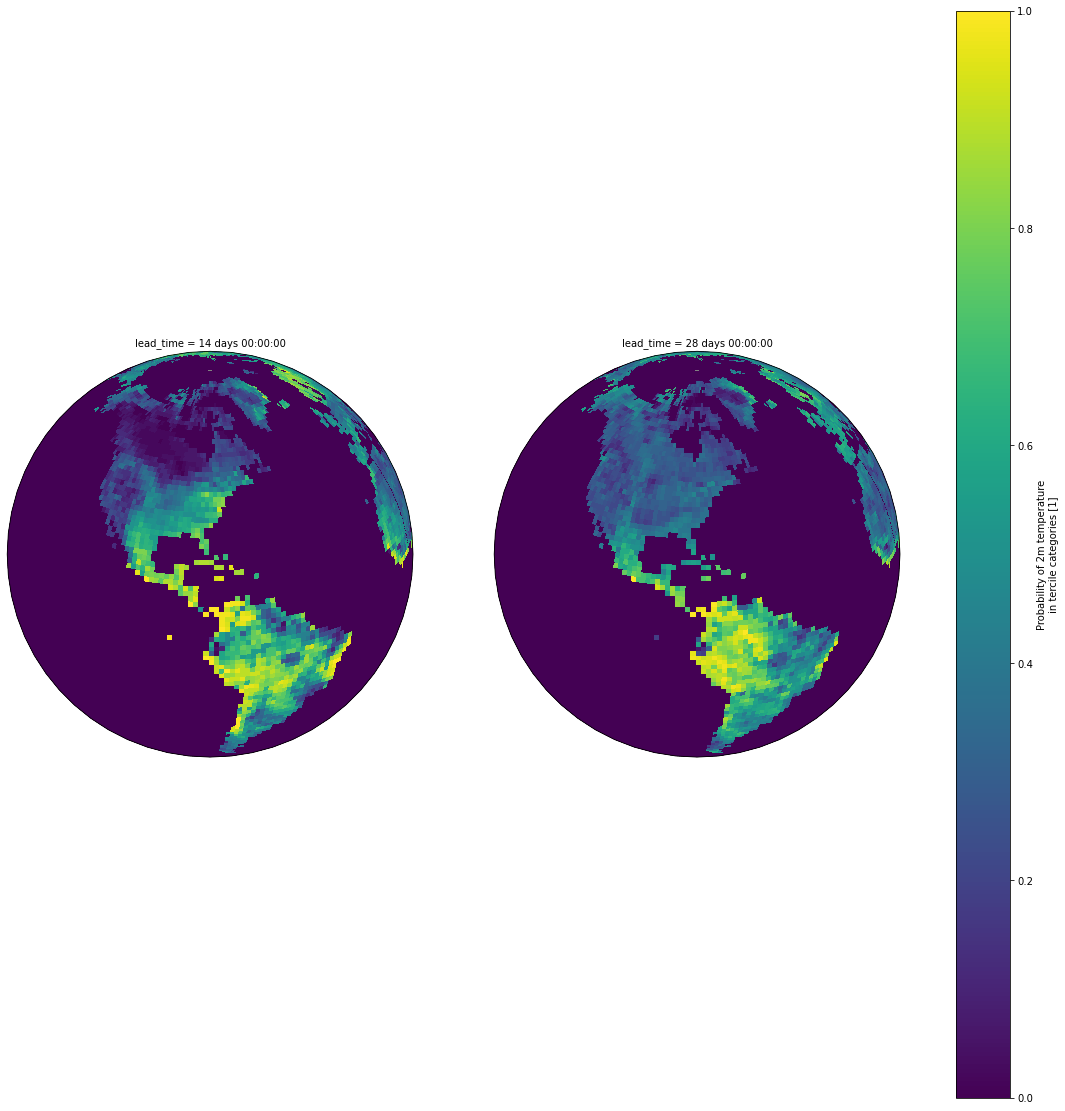

In [9]:
if SHOW_VISUALISATIONS:
    val.plot_by_region(what='predictions', region='North_America', orthographic=True)

Plot t2m for category n° 2 for predictions data for Europe_Africa_Asia for forecast_time 0


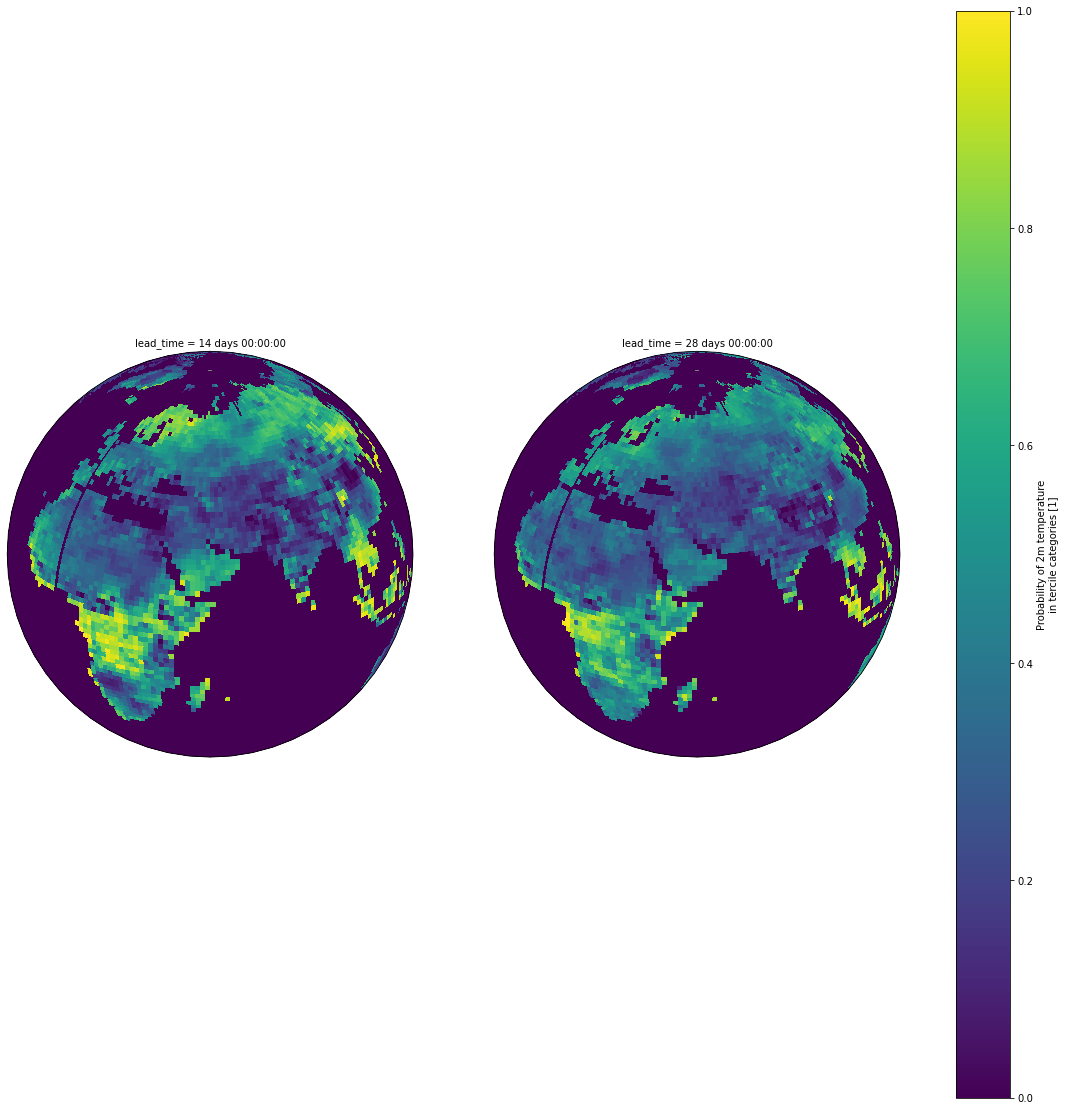

In [10]:
if SHOW_VISUALISATIONS:
    val.plot_by_region(what='predictions', region='Europe_Africa_Asia', orthographic=True)

Plot t2m for category n° 2 for predictions data for Oceania for forecast_time 0


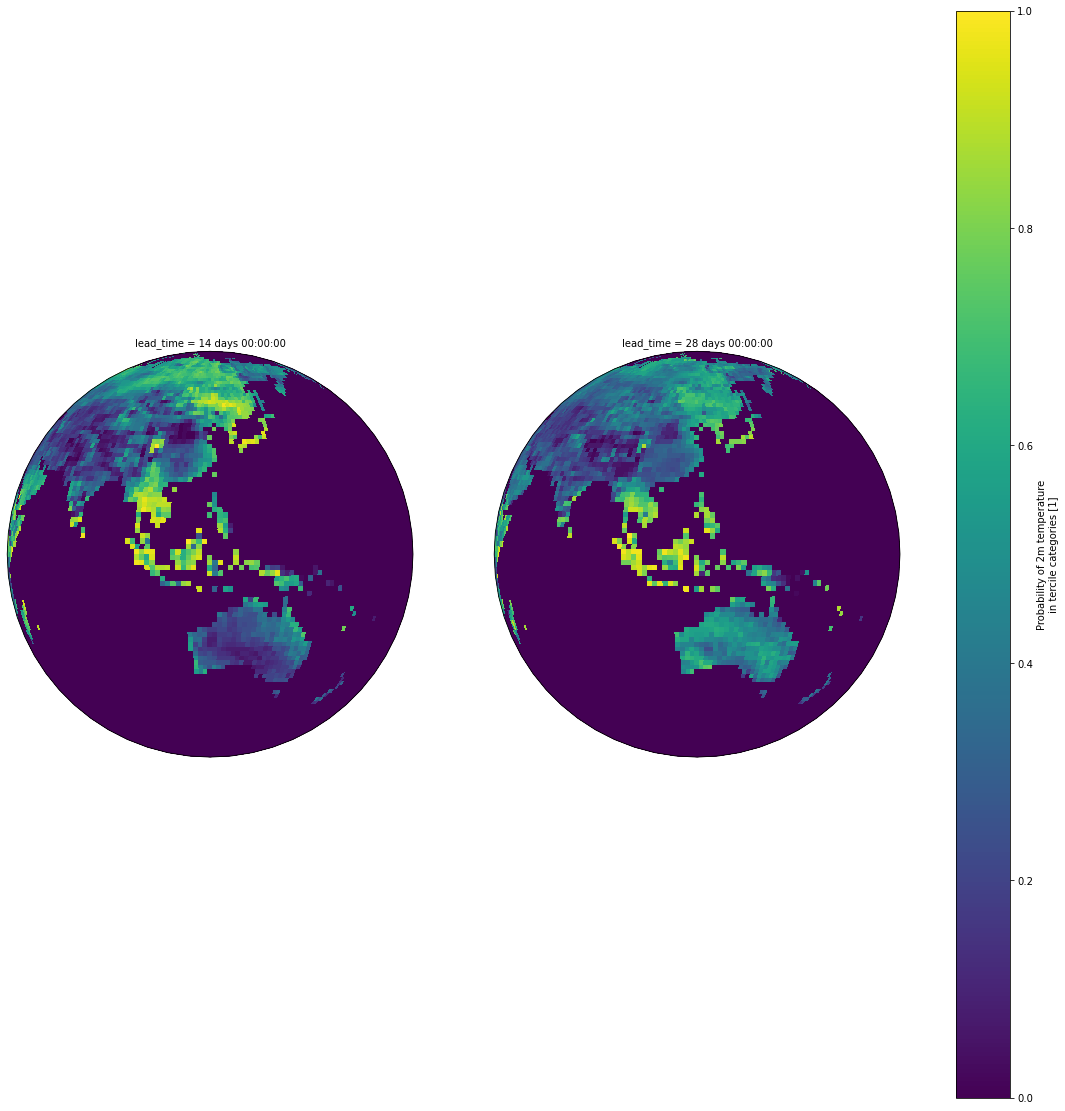

In [11]:
if SHOW_VISUALISATIONS:
    val.plot_by_region(what='predictions', region='Oceania', orthographic=True)

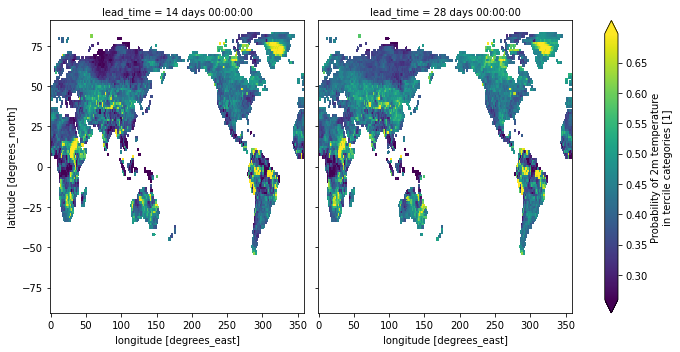

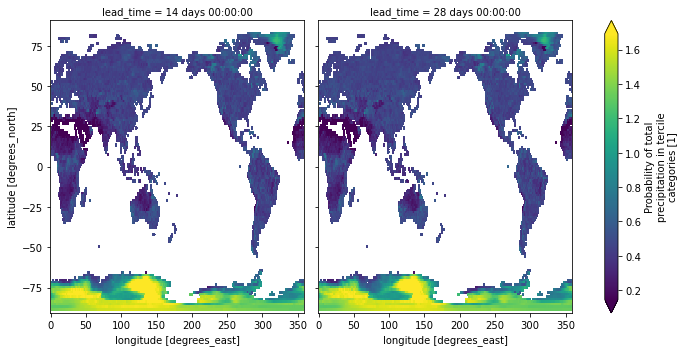

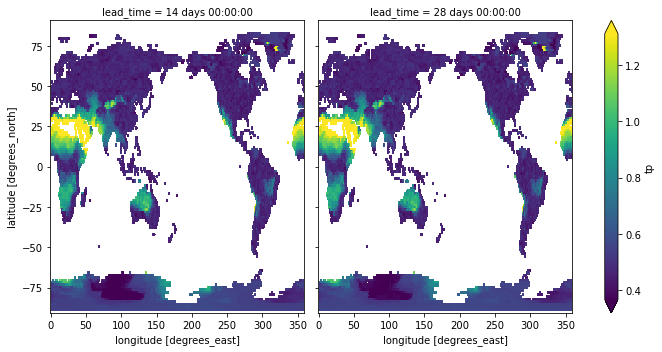

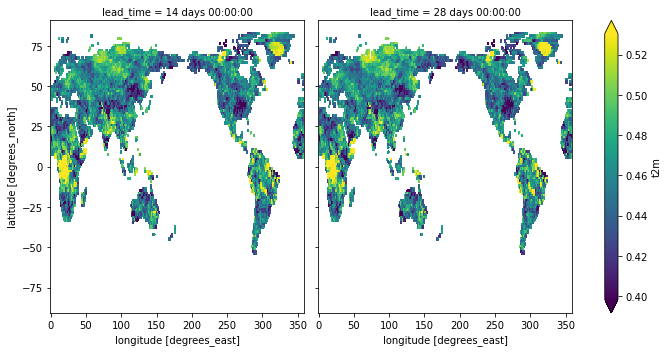

In [12]:
if SHOW_VISUALISATIONS:
    val.plot_rps()

## Compute RPPS from organizers and Arlan's formula

In [97]:
organizers_rpss = val.compute_scores_from_organizers_RPSS()

In [98]:
arlan_rpss = val.compute_scores_from_arlan_RPSS()

In [117]:
rpss = pd.concat([organizers_rpss, arlan_rpss], axis=1, keys=['Organizer RPSS', 'Arlan RPSS'])
rpss.style.background_gradient(cmap=CMAP).set_precision(2)

## Compute and plot monthly scores

Here you can set keep_tropics to True to compute scores in function of tropics defined by organizers

In [115]:
scores_monthly = val.compute_monthly_scores(keep_tropics=False)
scores_monthly.style.background_gradient(cmap=CMAP).set_precision(2)

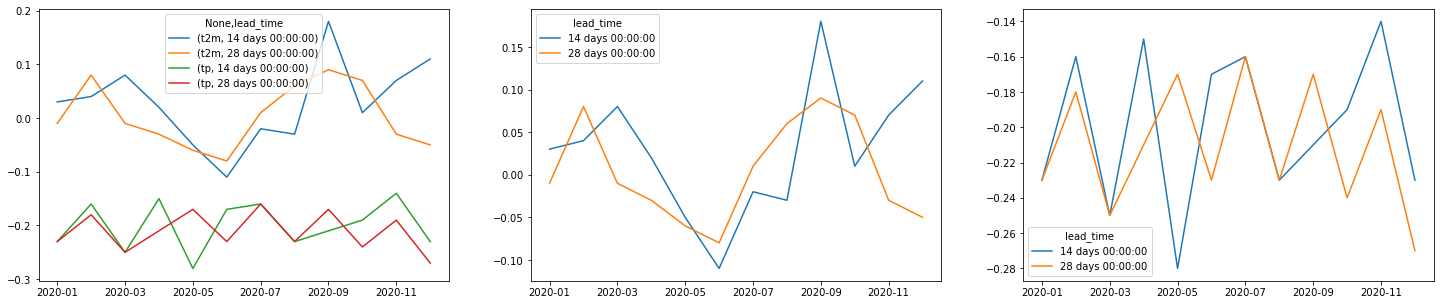

In [79]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(25, 5))
scores_monthly.transpose().plot(ax=axes[0])
scores_monthly.xs('t2m', axis=0).transpose().plot(ax=axes[1])
scores_monthly.xs('tp', axis=0).transpose().plot(ax=axes[2])

In [116]:
scores_monthly_withTropics = val.compute_monthly_scores(keep_tropics=True)
scores_monthly_withTropics.style.background_gradient(cmap=CMAP).set_precision(2)

## Compute and plot trimestrial scores

In [74]:
scores_trimestrials = val.compute_trimestrial_scores()

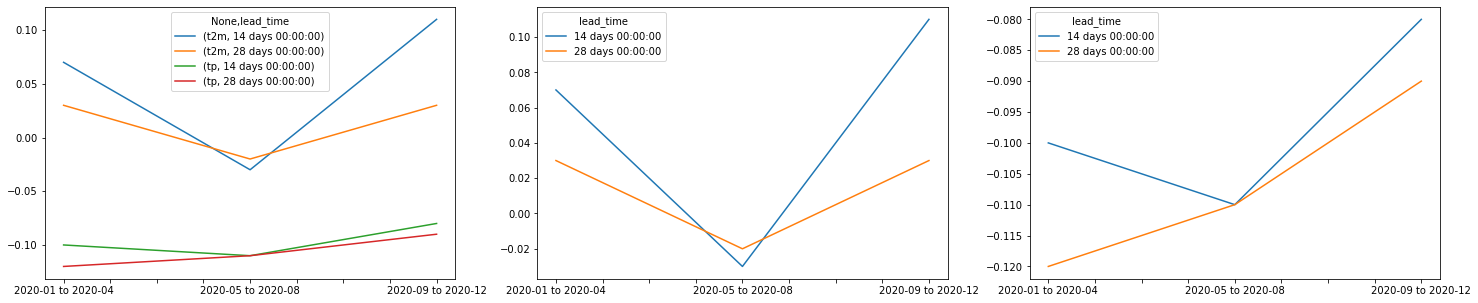

In [75]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(25, 5))
scores_trimestrials.transpose().plot(ax=axes[0]) 
scores_trimestrials.xs('t2m', axis=0).transpose().plot(ax=axes[1])
scores_trimestrials.xs('tp', axis=0).transpose().plot(ax=axes[2])

In [18]:
EXPORT_DATA = False
if EXPORT_DATA:
    
    save_directory: str = os.path.join(EXPORT_PATH, datetime.datetime.now().strftime('%Y-%m-%d-%H-%M-%S%f')[:-3])
    os.mkdir(save_directory)
    
    writer = pd.ExcelWriter(os.path.join(save_directory, "scores.xlsx"), engine='xlsxwriter')
    scores_monthly.to_excel(writer, sheet_name='Monthly scores')
    scores_trimestrials.to_excel(writer, sheet_name='Trimestrial scores')
    organizers_rpss.to_excel(writer, sheet_name='Organizers RPSS')
    arlan_rpss.to_excel(writer, sheet_name='Arlan RPSS')
    writer.save()

In [19]:
!jupyter nbconvert "JG - Validation.ipynb" --to html --output test_notebook.html

Traceback (most recent call last):
  File "/misc/binscratch/jupyterhub/bin/jupyter-nbconvert", line 5, in <module>
    from nbconvert.nbconvertapp import main
  File "/misc/binscratch/jupyterhub/lib/python3.6/site-packages/nbconvert/nbconvertapp.py", line 140, in <module>
    class NbConvertApp(JupyterApp):
  File "/misc/binscratch/jupyterhub/lib/python3.6/site-packages/nbconvert/nbconvertapp.py", line 225, in NbConvertApp
    """.format(formats=get_export_names()))
  File "/misc/binscratch/jupyterhub/lib/python3.6/site-packages/nbconvert/exporters/base.py", line 141, in get_export_names
    e = get_exporter(exporter_name)(config=config)
  File "/misc/binscratch/jupyterhub/lib/python3.6/site-packages/nbconvert/exporters/base.py", line 102, in get_exporter
    if getattr(exporter(config=config), 'enabled', True):
  File "/misc/binscratch/jupyterhub/lib/python3.6/site-packages/nbconvert/exporters/templateexporter.py", line 325, in __init__
    super().__init__(config=config, **kw)
  File

In [ ]:
# Printemps le 20 mars
# Été le 20 juin
# Automne 22 septembre
# Hiver 21 decembre